In [268]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator


In [340]:
Kenya_ex = pd.read_csv("Kenya2012_2022exportsHS2-6.csv")
Kenya_im = pd.read_csv("Kenya2012_2022importHS2-6.csv")
Africa_east = pd.read_csv("EastAfricadata.csv")


## First Data Inspection
This will cover methods use to inspect what kind of data types and the overall attributes of the dataframe.

In [338]:
Kenya_ex

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
40159,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,1849.00,2022,77
40160,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,638981.00,2022,77
40161,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2507.00,2022,77
40162,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,391474.00,2022,77


In [271]:
Kenya_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40164 entries, 0 to 40163
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HS2          40164 non-null  object 
 1   HS2 ID       40164 non-null  int64  
 2   HS4          40164 non-null  object 
 3   HS4 ID       40164 non-null  int64  
 4   HS6          40164 non-null  object 
 5   HS6 ID       40164 non-null  int64  
 6   Section      40164 non-null  object 
 7   Section ID   40164 non-null  int64  
 8   Trade Value  40164 non-null  float64
 9   Year         40164 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 3.1+ MB


In [274]:
Kenya_ex.mean(numeric_only=True)

HS2 ID            1133.21
HS4 ID          113334.84
HS6 ID        11333522.61
Section ID          10.78
Trade Value    1766068.43
Year              2016.98
dtype: float64

In [276]:
Kenya_ex.nunique(axis=0)

HS2               96
HS2 ID            96
HS4             1212
HS4 ID          1212
HS6             4514
HS6 ID          4522
Section           21
Section ID        21
Trade Value    31600
Year              11
dtype: int64

In [278]:
Kenya_ex.describe()

,HS2 ID,HS4 ID,HS6 ID,Section ID,Trade Value,Year
count,40164.00,40164.00,40164.00,40164.00,40164.00,40164.00
mean,1133.21,113334.84,11333522.61,10.78,1766068.43,2016.98
std,562.38,56242.16,5624219.61,5.35,24522157.32,3.14
min,101.00,10101.00,1010111.00,1.00,1.00,2012.00
25%,629.00,62933.00,6293390.00,6.00,3592.75,2014.00
50%,1161.00,116104.00,11610453.00,11.00,29066.50,2017.00
75%,1684.00,168420.00,16842099.00,16.00,198958.25,2020.00
max,2197.00,219706.00,21970600.00,21.00,1390004598.00,2022.00


In [280]:
Kenya_ex['Total_Industry_Count'] = Kenya_ex.groupby('Section ID')['Section'].transform('count')
Kenya_ex.rename(columns={'Trade Value': 'Trade_Value', 'Section ID': 'Section_ID', 'HS2 ID': 'HS2_ID', 'HS4 ID': 'HS4_ID','HS6 ID': 'HS6_ID' })

,HS2,HS2_ID,HS4,HS4_ID,HS6,HS6_ID,Section,Section_ID,Trade_Value,Year,Total_Industry_Count
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
40159,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,1849.00,2022,77
40160,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,638981.00,2022,77
40161,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2507.00,2022,77
40162,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,391474.00,2022,77


In [282]:
Kenya_section = Kenya_ex[Kenya_ex['Section'] == "Animal Products"]
Kenya_section

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
36750,"Animal originated products, n.e.s.",105,Coral and Shells,10508,Coral and Shells,1050800,Animal Products,1,176158.00,2022,1425
36751,"Animal originated products, n.e.s.",105,Pharmaceutical Animal Products,10510,Pharmaceutical Animal Products,1051000,Animal Products,1,269290.00,2022,1425
36752,"Animal originated products, n.e.s.",105,Other Inedible Animal Products,10511,Bovine Semen,1051110,Animal Products,1,245477.00,2022,1425
36753,"Animal originated products, n.e.s.",105,Other Inedible Animal Products,10511,Inedible Fish and Crustaceans,1051191,Animal Products,1,60427.00,2022,1425


In [284]:
Kenya_ex_2012 = Kenya_ex[Kenya_ex.Year == 2012].copy()
Kenya_ex_2012

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
3545,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,208799.00,2012,77
3546,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,772108.00,2012,77
3547,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2975.00,2012,77
3548,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,38048.00,2012,77


In [286]:
Kenya_ex_2012.nlargest(10, 'Trade Value')

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
217,"Coffee, tea, mate & spices",209,Tea,20902,"Black Tea (Fermented/Partly, >3kg packages)",2090240,Vegetable Products,2,1016246029.00,2012,2338
119,"Live trees, plants, bulbs, cut flowers, & orna...",206,Cut Flowers,20603,Fresh cut flowers and flower buds for bouquets,2060310,Vegetable Products,2,600137939.00,2012,2338
209,"Coffee, tea, mate & spices",209,Coffee,20901,Unroasted Coffee (Non-Decaffeinated),2090111,Vegetable Products,2,263959695.00,2012,2338
578,"Mineral fuels, mineral oils and products of th...",527,Refined Petroleum,52710,"Oils petroleum, bituminous, distillates, excep...",5271000,Mineral Products,5,230244373.00,2012,1076
2130,"Precious stones, metals, & pearls",1471,Gold,147108,Gold in unwrought forms non-monetary,14710812,Precious Metals,14,188987898.00,2012,303
140,"Edible vegetables, roots, & tubers",207,Legumes,20708,Beans Shelled or Unshelled (Fresh/Chilled),2070820,Vegetable Products,2,147474835.00,2012,2338
493,Tobacco & substitutes,424,Rolled Tobacco,42402,Cigarettes containing tobacco,4240220,Foodstuffs,4,84508167.00,2012,1679
3249,"Ships, boats, & floating structures",1789,Passenger and Cargo Ships,178901,Cargo vessels other than tanker or refrigerated,17890190,Transportation,17,83198425.00,2012,1042
694,Inorganic chemicals,628,Carbonates,62836,Disodium carbonate,6283620,Chemical Products,6,81199046.00,2012,5659
907,Pharmaceutical products,630,Packaged Medicaments,63004,"Medicaments nes, in dosage",6300490,Chemical Products,6,68846851.00,2012,5659


In [288]:
Kenya_ex_2022 = Kenya_ex[Kenya_ex.Year == 2022].copy()
Kenya_ex_2022


,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
36638,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,7556.00,2022,1425
36639,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,3643.00,2022,1425
36640,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,243891.00,2022,1425
36641,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,443989.00,2022,1425
36642,Live animals,101,Pigs,10103,Pure-bred Breeding Pigs,1010310,Animal Products,1,74587.00,2022,1425
...,...,...,...,...,...,...,...,...,...,...,...
40159,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,1849.00,2022,77
40160,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,638981.00,2022,77
40161,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2507.00,2022,77
40162,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,391474.00,2022,77


In [290]:
Kenya_ex_2022.nlargest(10,'Trade Value') 

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
36873,"Coffee, tea, mate & spices",209,Tea,20902,"Black Tea (Fermented/Partly, >3kg packages)",2090240,Vegetable Products,2,1349478193.00,2022,2338
36762,"Live trees, plants, bulbs, cut flowers, & orna...",206,Cut Flowers,20603,Fresh cut flowers and flower buds for bouquets,2060310,Vegetable Products,2,657707132.00,2022,2338
36864,"Coffee, tea, mate & spices",209,Coffee,20901,Unroasted Coffee (Non-Decaffeinated),2090111,Vegetable Products,2,328443297.00,2022,2338
37222,"Ores, slag and ash",526,Titanium Ore,52614,Titanium ores and concentrates,5261400,Mineral Products,5,289848082.00,2022,1076
36833,"Edible fruits, nuts & fruit peels",208,Tropical Fruits,20804,Avocados (Fresh/Dried),2080440,Vegetable Products,2,182406315.00,2022,2338
38773,"Precious stones, metals, & pearls",1471,Gold,147108,Gold in unwrought forms non-monetary,14710812,Precious Metals,14,159845146.00,2022,303
36987,"Animal or vegetable fats, oils, & waxes",315,Palm Oil,31511,Palm oil or fractions simply refined,3151190,Animal and Vegetable Bi-Products,3,146365408.00,2022,463
36828,"Edible fruits, nuts & fruit peels",208,Other Nuts,20802,Other Fresh/Dried Edible Nuts,2080290,Vegetable Products,2,105677032.00,2022,2338
37350,Inorganic chemicals,628,Carbonates,62836,Disodium carbonate,6283620,Chemical Products,6,98806945.00,2022,5659
37163,Tobacco & substitutes,424,Rolled Tobacco,42402,Cigarettes containing tobacco,4240220,Foodstuffs,4,97178603.00,2022,1679


In [292]:
def most_traded(year, section, n):
    return Kenya_ex[(Kenya_ex.Year == year) &  (Kenya_ex.Section == section)].nlargest(n, 'Trade Value')

In [294]:
most_traded(2018, 'Animal Products', 5)

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
22154,Meat & edible offal,102,Sheep and Goat Meat,10204,Goat Meat,1020450,Animal Products,1,33147783.00,2018,1425
22191,"Fish, crustaceans, & molluscs",103,Non-fillet Frozen Fish,10303,Fish (Other Varieties) (Frozen),1030379,Animal Products,1,23728098.00,2018,1425
22194,"Fish, crustaceans, & molluscs",103,Fish Fillets,10304,Fish Fillets (Frozen),1030420,Animal Products,1,12200615.00,2018,1425
22228,"Edible products of animal origin, n.e.s.",104,Concentrated Milk,10402,Unsweetened Cream Powder (<1.5% Fat),1040221,Animal Products,1,11878264.00,2018,1425
22155,Meat & edible offal,102,Horse Meat,10205,"Meat from Horses/Donkeys/Mules/Hinnies (Fresh,...",1020500,Animal Products,1,8898610.00,2018,1425


In [296]:
most_traded(2022,'Animal Products', 5)

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
36666,Meat & edible offal,102,Sheep and Goat Meat,10204,Goat Meat,1020450,Animal Products,1,50461216.00,2022,1425
36658,Meat & edible offal,102,Sheep and Goat Meat,10204,Fresh/Chilled Lamb (Whole & Halves),1020410,Animal Products,1,17887312.00,2022,1425
36659,Meat & edible offal,102,Sheep and Goat Meat,10204,Fresh/Chilled Sheep (Whole & Halves),1020421,Animal Products,1,15570623.00,2022,1425
36704,"Fish, crustaceans, & molluscs",103,"Fish: dried, salted, smoked or in brine",10305,Dried Cod (Not Smoked),1030551,Animal Products,1,12346551.00,2022,1425
36648,Live animals,101,Other Animals,10106,Live Animals (Not Farm Types),1010600,Animal Products,1,9120787.00,2022,1425


In [298]:
Kenya_section = Kenya_ex[Kenya_ex.Section == 'Animal Products'].copy()
Kenya_section
#looking at one certain section to find counts

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
36750,"Animal originated products, n.e.s.",105,Coral and Shells,10508,Coral and Shells,1050800,Animal Products,1,176158.00,2022,1425
36751,"Animal originated products, n.e.s.",105,Pharmaceutical Animal Products,10510,Pharmaceutical Animal Products,1051000,Animal Products,1,269290.00,2022,1425
36752,"Animal originated products, n.e.s.",105,Other Inedible Animal Products,10511,Bovine Semen,1051110,Animal Products,1,245477.00,2022,1425
36753,"Animal originated products, n.e.s.",105,Other Inedible Animal Products,10511,Inedible Fish and Crustaceans,1051191,Animal Products,1,60427.00,2022,1425


In [300]:
# Group by year and section to find the total trade value per section per year
# This will show the Year and Section as the multi-level indices
yearly_exports = Kenya_ex.groupby(['Year', 'Section'])['Trade Value'].sum().reset_index()

# Pivot the data to get a better format for plotting
pivot_exports = yearly_exports.pivot(index='Year', columns='Section', values='Trade Value').fillna(0)

In [345]:
yearly_exports

,Year,Section,Trade Value
0,2012,Animal Hides,116632342.00
1,2012,Animal Products,135418990.00
2,2012,Animal and Vegetable Bi-Products,66038164.00
3,2012,Arts and Antiques,1659069.00
4,2012,Chemical Products,345872493.00
...,...,...,...
226,2022,Textiles,605827075.00
227,2022,Transportation,53571783.00
228,2022,Vegetable Products,3145773148.00
229,2022,Weapons,2127.00


In [302]:
pivot_exports

Section,Animal Hides,Animal Products,Animal and Vegetable Bi-Products,Arts and Antiques,Chemical Products,Foodstuffs,Footwear and Headwear,Instruments,Machines,Metals,...,Miscellaneous,Paper Goods,Plastics and Rubbers,Precious Metals,Stone And Glass,Textiles,Transportation,Vegetable Products,Weapons,Wood Products
Year,,,,,,,,,,,,,,,,,,,,,
2012,116632342.00,135418990.00,66038164.00,1659069.00,345872493.00,447239115.00,27663162.00,15527412.00,203615157.00,202661357.00,...,33910953.00,76292025.00,136594973.00,196967554.00,24945882.00,331517475.00,199439103.00,2412270993.00,1527574.00,9086484.00
2013,112220685.00,124667792.00,125003582.00,1821453.00,480833483.00,570274584.00,60976270.00,28835662.00,217383840.00,337329436.00,...,62826277.00,119802494.00,213538397.00,240704637.00,38346548.00,413784164.00,104121311.00,2417740145.00,1971933.00,41175258.00
2014,141457437.00,134873618.00,75124494.00,1882439.00,488328854.00,433851426.00,35779614.00,22739869.00,171520661.00,247101317.00,...,50806518.00,123108274.00,128582572.00,43025848.00,19064389.00,482539558.00,99389581.00,2578198504.00,777.00,34674383.00
2015,82645361.00,111601846.00,82245616.00,1421631.00,461369577.00,582523916.00,52767745.00,28056349.00,197298739.00,274297532.00,...,66249191.00,127542336.00,180083105.00,31325260.00,23116691.00,470830248.00,106387914.00,2577431750.00,583460.00,11092510.00
2016,73830856.00,101775906.00,112575979.00,1127653.00,410869328.00,514798349.00,45436252.00,20373711.00,250040870.00,261355606.00,...,62945479.00,124187584.00,154403192.00,23222474.00,17062528.00,456785423.00,148584078.00,2616072962.00,129833.00,8218357.00
2017,104629787.00,115390523.00,99775544.00,1589063.00,412506607.00,523228057.00,43368941.00,17708399.00,147832657.00,262883483.00,...,59221420.00,122687409.00,140120205.00,33257811.00,21556487.00,438181916.00,77720265.00,2882388029.00,194153.00,7172886.00
2018,90390572.00,151698807.00,123363162.00,2298086.00,477717341.00,539993544.00,43114233.00,26040724.00,248114707.00,259794215.00,...,55448712.00,153264586.00,128948592.00,90027435.00,28880423.00,525333504.00,98664402.00,2957420941.00,13026.00,17715339.00
2019,41786437.00,137695181.00,143327208.00,1205974.00,454988369.00,518514081.00,51749147.00,24786871.00,248392625.00,278387861.00,...,56417739.00,114872051.00,121647274.00,364599114.00,28965974.00,473223399.00,114034212.00,2625478192.00,26846.00,14605355.00
2020,26702023.00,129464027.00,196689174.00,1060881.00,479694147.00,595000746.00,51326916.00,23657599.00,159271824.00,278106842.00,...,58739158.00,126661664.00,125481971.00,434598276.00,28045724.00,454070290.00,61680460.00,2778766909.00,373201.00,15943067.00


In [304]:
# Create a correlation matrix using pandas

# Exclude non-numeric columns
corr_matrix = pivot_exports.select_dtypes(include=[ 'float64', 'int64'])

# Now compute the correlation matrix
corr_matrix= pivot_exports.corr()
corr_matrix

Section,Animal Hides,Animal Products,Animal and Vegetable Bi-Products,Arts and Antiques,Chemical Products,Foodstuffs,Footwear and Headwear,Instruments,Machines,Metals,...,Miscellaneous,Paper Goods,Plastics and Rubbers,Precious Metals,Stone And Glass,Textiles,Transportation,Vegetable Products,Weapons,Wood Products
Section,,,,,,,,,,,,,,,,,,,,,
Animal Hides,1.00,-0.29,-0.82,0.63,-0.51,-0.67,-0.60,-0.46,-0.10,-0.57,...,-0.55,-0.37,0.18,-0.57,-0.43,-0.51,0.38,-0.59,0.19,0.32
Animal Products,-0.29,1.00,0.64,0.38,0.59,0.02,0.09,0.16,-0.20,0.49,...,0.03,0.34,-0.27,0.33,0.74,0.60,-0.35,0.58,-0.16,0.22
Animal and Vegetable Bi-Products,-0.82,0.64,1.00,-0.28,0.78,0.58,0.62,0.46,-0.18,0.85,...,0.60,0.53,-0.04,0.48,0.76,0.71,-0.59,0.76,-0.12,0.06
Arts and Antiques,0.63,0.38,-0.28,1.00,0.06,-0.30,-0.29,-0.05,0.01,-0.10,...,-0.28,0.21,0.08,-0.39,0.15,0.08,-0.00,0.03,0.07,0.44
Chemical Products,-0.51,0.59,0.78,0.06,1.00,0.52,0.68,0.71,-0.12,0.86,...,0.72,0.75,0.14,0.18,0.65,0.86,-0.72,0.67,-0.15,0.46
Foodstuffs,-0.67,0.02,0.58,-0.30,0.52,1.00,0.86,0.56,0.00,0.62,...,0.77,0.55,0.41,0.33,0.49,0.39,-0.57,0.41,0.12,-0.02
Footwear and Headwear,-0.60,0.09,0.62,-0.29,0.68,0.86,1.00,0.68,0.10,0.82,...,0.87,0.54,0.55,0.33,0.61,0.48,-0.57,0.33,0.15,0.30
Instruments,-0.46,0.16,0.46,-0.05,0.71,0.56,0.68,1.00,0.40,0.64,...,0.61,0.46,0.31,0.11,0.38,0.45,-0.26,0.39,0.28,0.33
Machines,-0.10,-0.20,-0.18,0.01,-0.12,0.00,0.10,0.40,1.00,-0.11,...,-0.01,-0.01,0.07,-0.03,-0.14,-0.10,0.53,-0.18,0.20,-0.03


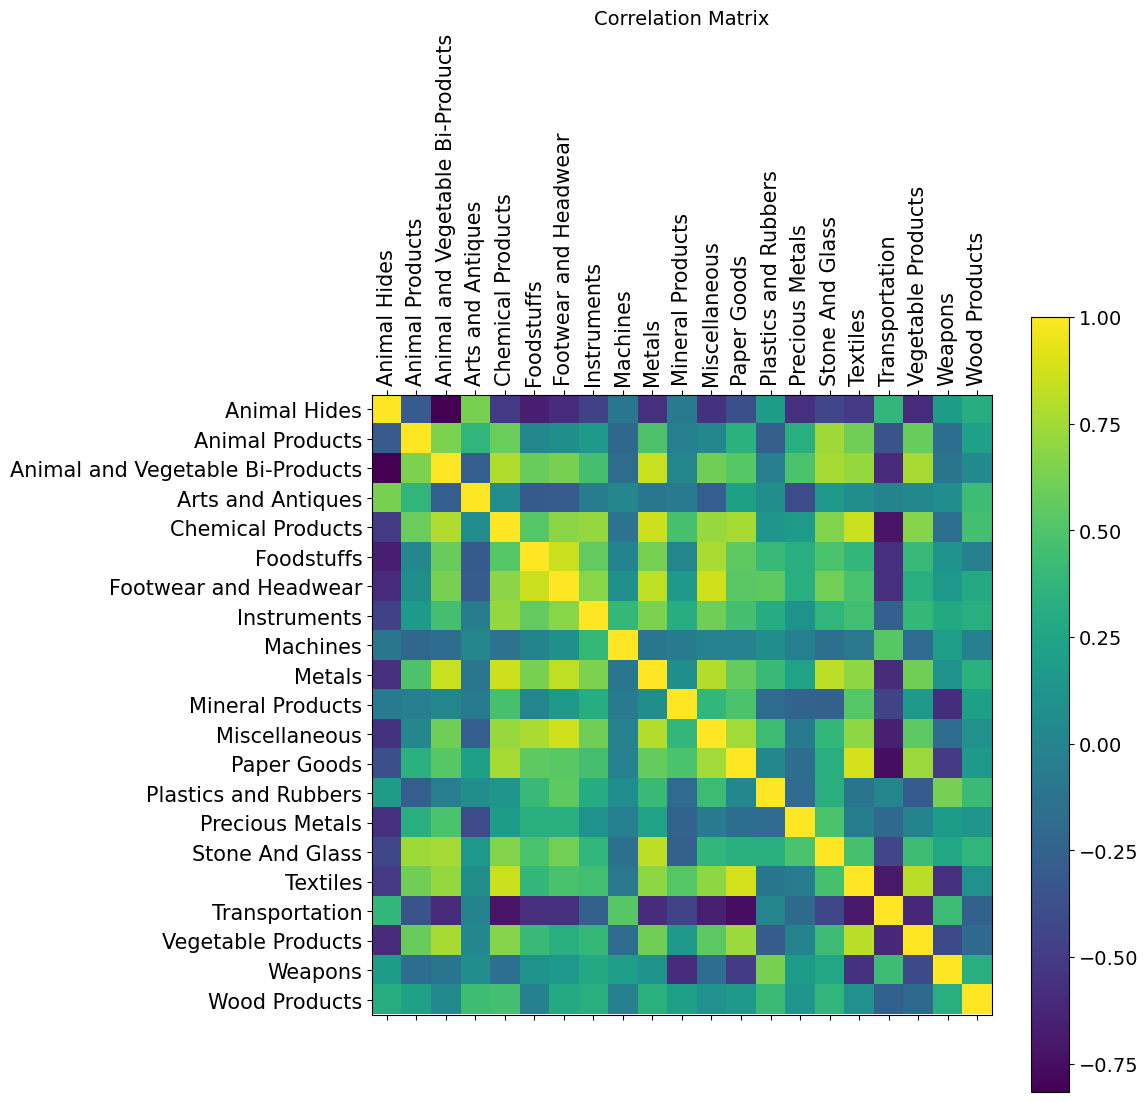

In [306]:

f = plt.figure(figsize=(10, 10)) # figure size 
plt.matshow(pivot_exports.corr(), fignum=f.number) # type of plot
plt.xticks(range(pivot_exports.shape[1]), pivot_exports.columns, fontsize=15, rotation=90) # x axis labels
plt.yticks(range(pivot_exports.shape[1]), pivot_exports.columns, fontsize=15) # y axis labels
cb = plt.colorbar() # add a colour legend (called colorbar)
cb.ax.tick_params(labelsize=14) # add font size
plt.title('Correlation Matrix', fontsize=14) # add title
plt.show() 

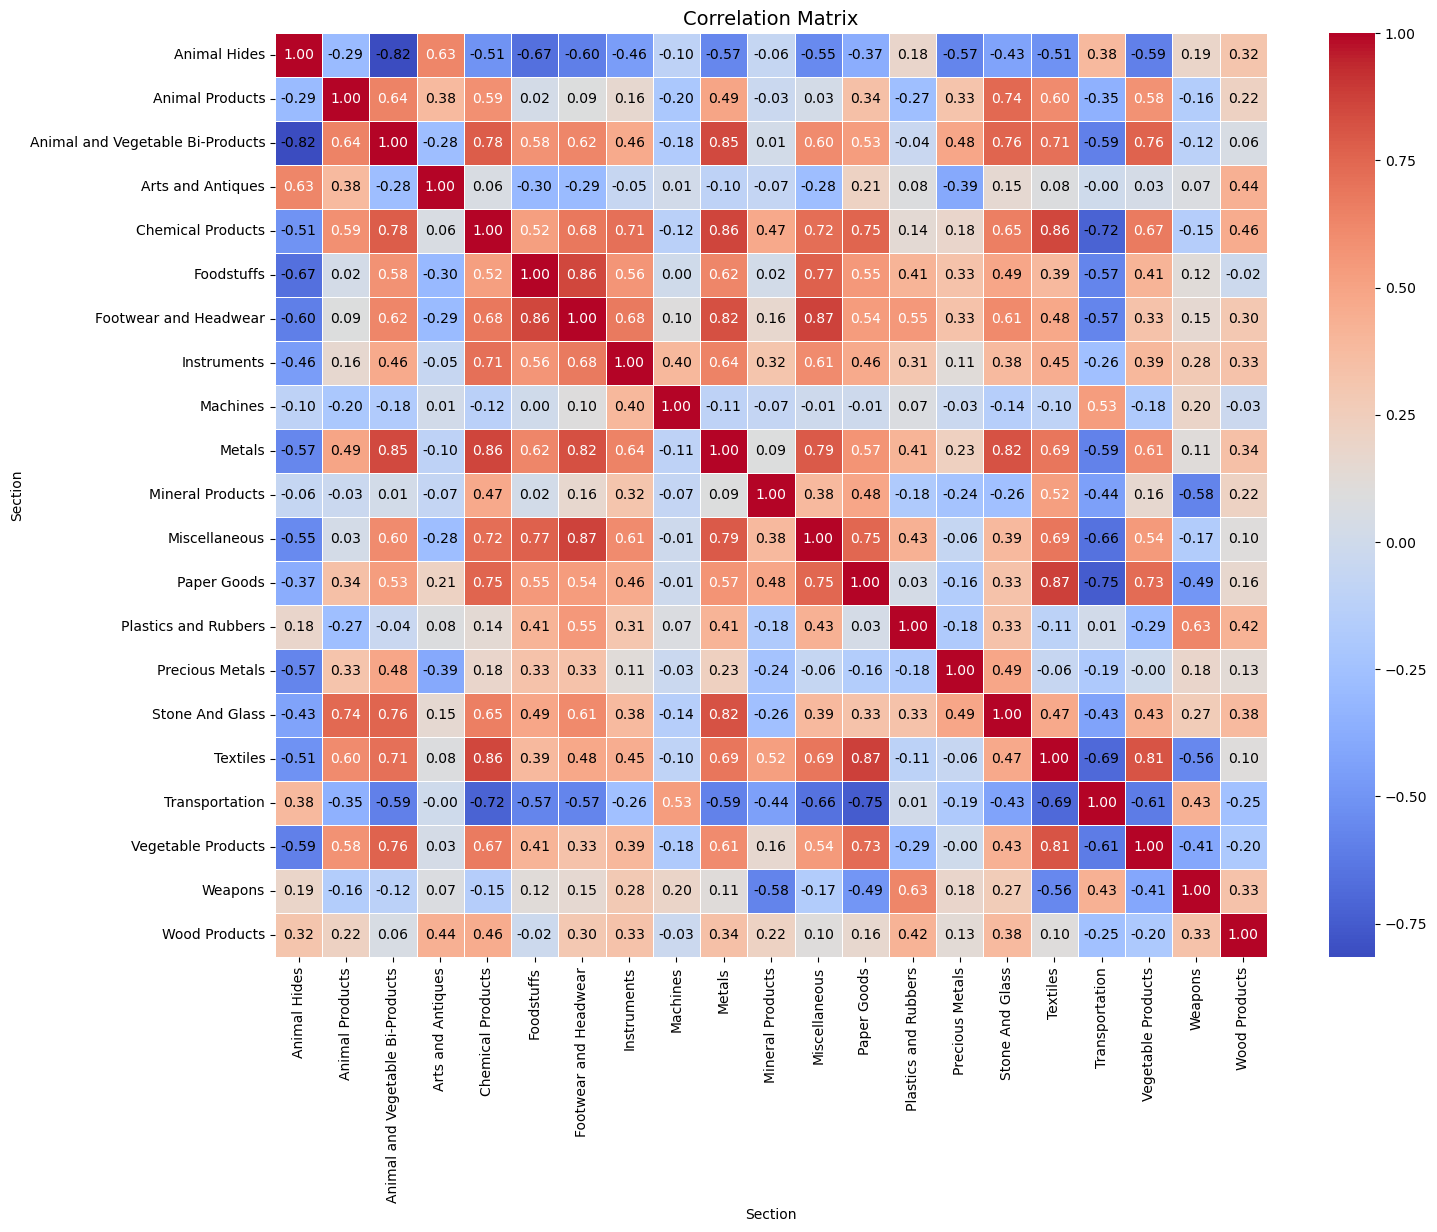

In [307]:
corr_matrix = pivot_exports.corr()
f, ax = plt.subplots(figsize=(16, 12))
# Create the heatmap without annotations
sns.heatmap(corr_matrix, annot=False, ax=ax, cmap='coolwarm', linewidths=0.5)

# Define a threshold to distinguish dark and light cells
threshold = corr_matrix.max().max() / 2  # This is an example threshold

# Manually annotate each cell with the correlation coefficient
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        text_color = "black" if value < threshold else "white"
        ax.text(j + 0.5, i + 0.5, f"{value:.2f}",
                horizontalalignment='center',
                verticalalignment='center',
                color=text_color)



# Now we set the title
plt.title('Correlation Matrix', fontsize=14)

# and finally show the plot
plt.show()

In [336]:
Kenya_exmerge = Kenya_ex_2022[["HS6", "Trade Value"]].merge (Kenya_ex_2012[["HS6","Trade Value"]], how = "inner", on = "HS6", 
                                                             suffixes = ("_2022", "_2012"))
Kenya_exmerge

,HS6,Trade Value_2022,Trade Value_2012
0,Pure-bred Breeding Horses,7556.00,3846.00
1,Non-breeding Horses,3643.00,13300.00
2,Pure-bred Breeding Cattle,243891.00,56766.00
3,Non-breeding Cattle,443989.00,2624789.00
4,Pure-bred Breeding Pigs,74587.00,5893.00
...,...,...,...
3092,"Original engravings, prints and lithographs",1849.00,208799.00
3093,"Original sculptures and statuary, in any material",638981.00,772108.00
3094,"Used postage and revenue stamps, first day cov...",2507.00,2975.00
3095,Collections and collectors pieces,391474.00,38048.00


C:\Users\Windows10\AppData\Local\Temp\ipykernel_10872\725622448.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
C:\Users\Windows10\AppData\Local\Temp\ipykernel_10872\725622448.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


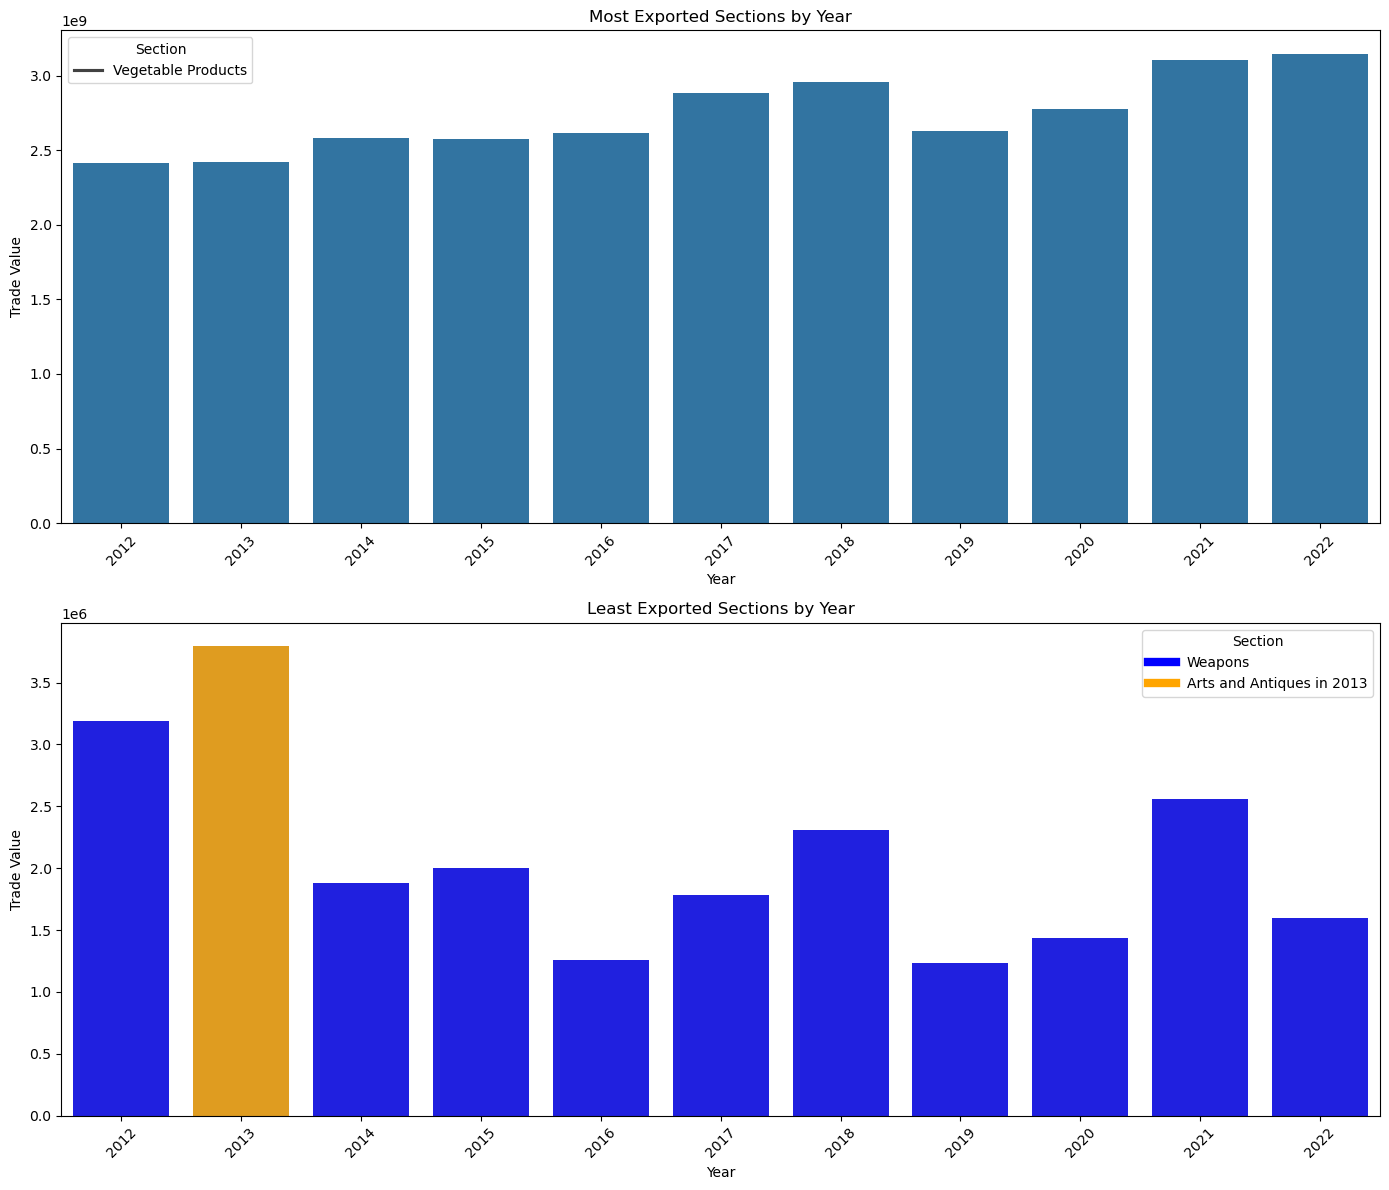

In [443]:

# Get the most and least exported sections
most_exported = pivot_exports.idxmax(axis=1)
least_exported = pivot_exports.idxmin(axis=1)

# Filter the unique labels for both graphs
most_exported_sections = most_exported.unique()
least_exported_sections = least_exported.unique()

# Get the sum of the trade values for each section
most_exported_data = pivot_exports[most_exported_sections].sum(axis=1)
least_exported_data = pivot_exports[least_exported_sections].sum(axis=1)

# Create the bar plot
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Plot for most exported sections
sns.barplot(x=most_exported_data.index, y=most_exported_data.values, ax=ax[0])
ax[0].set_title('Most Exported Sections by Year')
ax[0].set_ylabel('Trade Value')
ax[0].set_xlabel('Year')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].legend(labels=most_exported_sections, title='Section')

# Custom color list for least exported sections
colors = ['blue'] * len(least_exported_data)
year_2013_index = least_exported_data.index.get_loc(2013)  # Find the index for the year 2013
if least_exported[2013] == 'Arts and Antiques':
    colors[year_2013_index] = 'orange'

# Plot for least exported sections with custom colors
sns.barplot(x=least_exported_data.index, y=least_exported_data.values, hue=least_exported_data.index, ax=ax[1], palette=colors)
ax[1].set_title('Least Exported Sections by Year')
ax[1].set_ylabel('Trade Value')
ax[1].set_xlabel('Year')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

# Custom legend
legend_handles = [plt.Line2D([0], [0], color='blue', lw=6, label='Weapons'),
                  plt.Line2D([0], [0], color='orange', lw=6, label='Arts and Antiques in 2013')]
ax[1].legend(handles=legend_handles, title='Section')

plt.tight_layout()
plt.show()

In [447]:
least_exported, most_exported

(Year
 2012              Weapons
 2013    Arts and Antiques
 2014              Weapons
 2015              Weapons
 2016              Weapons
 dtype: object,
 Year
 2012    Vegetable Products
 2013    Vegetable Products
 2014    Vegetable Products
 2015    Vegetable Products
 2016    Vegetable Products
 2017    Vegetable Products
 2018    Vegetable Products
 2019    Vegetable Products
 2020    Vegetable Products
 2021    Vegetable Products
 2022    Vegetable Products
 dtype: object)

In [259]:
#Next we do the imports for Kenya
Kenya_im_2012 = Kenya_im[Kenya_im.Year == 2012 ].copy()
Kenya_im_2012

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,185562.00,2012
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,16239.00,2012
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,8204.00,2012
3,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,12187.00,2012
4,Live animals,101,Sheep and Goats,10104,Live Sheep,1010410,Animal Products,1,5.00,2012
...,...,...,...,...,...,...,...,...,...,...
4108,Art & antiques,2197,Paintings,219701,"Collages, similar decorative plaques",21970190,Arts and Antiques,21,280945.00,2012
4109,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,22842.00,2012
4110,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,10716100.00,2012
4111,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,270.00,2012


In [53]:
Kenya_im_2022 = Kenya_im[Kenya_im.Year == 2022 ].copy()
Kenya_im_2022

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year
42132,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,402123.00,2022
42133,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13145.00,2022
42134,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,2098061.00,2022
42135,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2873054.00,2022
42136,Live animals,101,Pigs,10103,Pigs Weighing Over 50 kg (Excluding Breeding P...,1010392,Animal Products,1,2726.00,2022
...,...,...,...,...,...,...,...,...,...,...
46363,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,12479.00,2022
46364,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,68007.00,2022
46365,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,4810.00,2022
46366,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,82799.00,2022


In [54]:
total_products = industry_counts.sum()
print("Total Products across all Industries:", total_products)

NameError: name 'industry_counts' is not defined

#This is the Industry Trade value

In [ ]:
industry_trade_value = df.groupby('Section')['Trade Value'].sum()
highest_trade_value_industry = industry_trade_value.idxmax()
highest_trade_value = industry_trade_value.max()
lowest_trade_value_industry = industry_trade_value.idxmin()
lowest_trade_value = industry_trade_value.min()

#Highest and lowest value of trade value within an Industry


print(f"The industry with the lowest trade value is '{lowest_trade_value_industry}' with a total trade value of {lowest_trade_value}.")
print(f"The industry with the highest trade value is '{highest_trade_value_industry}' with a total trade value of {highest_trade_value}.")

In [ ]:
df.describe(include="all")

In [187]:
Kenya_ex

,HS2,HS2 ID,HS4,HS4 ID,HS6,HS6 ID,Section,Section ID,Trade Value,Year,Total_Industry_Count
0,Live animals,101,Horses,10101,Pure-bred Breeding Horses,1010111,Animal Products,1,3846.00,2012,1425
1,Live animals,101,Horses,10101,Non-breeding Horses,1010119,Animal Products,1,13300.00,2012,1425
2,Live animals,101,Horses,10101,"Live Donkeys, Mules, and Crossbreeds",1010120,Animal Products,1,9355.00,2012,1425
3,Live animals,101,Bovine,10102,Pure-bred Breeding Cattle,1010210,Animal Products,1,56766.00,2012,1425
4,Live animals,101,Bovine,10102,Non-breeding Cattle,1010290,Animal Products,1,2624789.00,2012,1425
...,...,...,...,...,...,...,...,...,...,...,...
40159,Art & antiques,2197,Prints,219702,"Original engravings, prints and lithographs",21970200,Arts and Antiques,21,1849.00,2022,77
40160,Art & antiques,2197,Sculptures,219703,"Original sculptures and statuary, in any material",21970300,Arts and Antiques,21,638981.00,2022,77
40161,Art & antiques,2197,Revenue Stamps,219704,"Used postage and revenue stamps, first day cov...",21970400,Arts and Antiques,21,2507.00,2022,77
40162,Art & antiques,2197,Collector's Items,219705,Collections and collectors pieces,21970500,Arts and Antiques,21,391474.00,2022,77


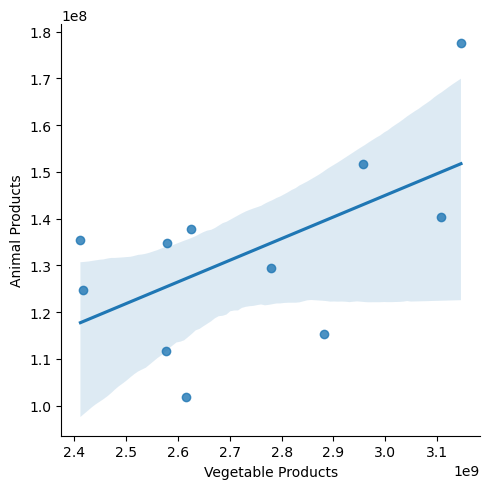

In [209]:
sns.lmplot(x='Vegetable Products', y='Animal Products', data= pivot_exports)

In [78]:
Africa_east.drop(columns= 'Unnamed: 0')

,Country Name,Country Code,Year,GDP growth (annual %),Trade (% of GDP)
0,Comoros,COM,2012,3.17,40.81
1,Eritrea,ERI,2012,NaN,NaN
2,Ethiopia,ETH,2012,8.65,45.40
3,Kenya,KEN,2012,4.57,51.62
4,Madagascar,MDG,2012,3.01,52.65
...,...,...,...,...,...
127,Somalia,SOM,2022,2.43,95.84
128,South Sudan,SSD,2022,NaN,NaN
129,Sudan,SDN,2022,-0.95,2.70
130,Tanzania,TZA,2022,4.56,35.02


In [ ]:
def billions_formatter(x, pos):
    return f'{x / 1e9:.0f}B'  # Convert value to billions and format

# Create a new formatter using the billions_formatter function
formatter = FuncFormatter(billions_formatter)

# Plotting code
plt.figure(figsize=(10, 6))
yearly_trade_sum.plot(kind='bar', color='skyblue')
plt.title('Total Trade Value by Year')
plt.xlabel('Year')
plt.ylabel('Total Trade Value (Billions)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines only on the y-axis

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [ ]:
unique_products_count = df.groupby('Year')['Section'].nunique()


# Industry Count Analysis
# Calculate count of unique industries within each section
industry_counts = df.groupby('Section')['HS2'].nunique()

# Calculate summary statistics for industry counts
industry_counts_summary = industry_counts.describe()

# Visualize distribution of industry counts across sections
# Example: Bar plot for industry counts
plt.figure(figsize=(10, 6))
industry_counts.plot(kind='bar', color='skyblue')
plt.title('Industry Count Distribution Across Sections')
plt.xlabel('Section')
plt.ylabel('Industry Count')
plt.xticks(rotation=45,fontsize=6)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print summary statistics for industry counts
print("Summary Statistics for Industry Counts:")
print(industry_counts_summary)

### 21 Industry in total
### Each unique industry (section) has at least 4.57 HS2(products)
### For how much the counts of unique industries or HS2 products vary from the mean value across different sections.
    - low std = low variation between HS2 (products) and Sections (unique industries)
    - High std = vice versa

# Assuming you have defined the trade summary DataFrame containing yearly trade sum, mean trade value, min trade value, and max trade value
# Also assuming df contains the trade data for Kenya

# Define the trade summary DataFrame (as per your provided code)
trade_summary = pd.DataFrame({
    'Mean Trade Value': mean_trade_value_kenya,})

# Plotting separate line graphs for Mean, Min, and Max trade values
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Trade Value
ax.plot(trade_summary.index, trade_summary['Mean Trade Value'], label='Mean Trade Value', marker='o', color='orange')


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Trade Value')
ax.set_title('MeanTrade Values for Kenya (2012-2022)')

# Add legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:

trade_summary = pd.DataFrame({
    'Min Trade Value': min_trade_value_kenya,})

# Plotting separate line graphs for Mean, Min, and Max trade values
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Trade Value
ax.plot(trade_summary.index, trade_summary['Min Trade Value'], label='Min Trade Value', marker='o', color='red')


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Trade Value')
ax.set_title('Min Trade Values for Kenya (2012-2022)')

# Add legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

Distribution of Trade by Section: Analyze the distribution of trade value across different sections to identify which sectors contribute the most to overall trade. You can calculate summary statistics (e.g., mean, median, standard deviation) of trade values for each section and visualize the distribution using histograms or box plots.

Trend Analysis: Examine the trend in trade value over time (Year) to identify any patterns or changes in trade dynamics. Plotting the trade value against time (Year) and fitting a trend line can help visualize the overall trend and identify any significant fluctuations or trends.

Comparative Analysis: Compare trade values across different HS2 categories to identify which product categories contribute the most to overall traCan calculate summary statistics for trade values within each HS2 category and compare them to assess their relative importance.

Seasonal Analysis: If the data spans multiple years, you can perform seasonal analysis to identify any seasonal patterns or fluctuations in trade values. This can help identify peak trading seasons or periods of low activity, which may influence business decisions and strategies.

Correlation Analysis: Explore the relationship between trade value and other variables such as Section ID or Industry_Count. You can calculate correlation coefficients to quantify the strength and direction of the relationship and identify any variables that may be correlated with trade value.

Outlier Detection: Identify outliers in trade values that may indicate unusual or exceptional trading activity. You can use statistical methods such as z-scores or interquartile range (IQR) to detect outliers and investigate any potential reasons for their occurrence.

Trade Dynamics by Year: Analyze how trade dynamics have evolved over the years by comparing trade values and industry counts across different years. This can help identify trends or shifts in trade patterns over time and inform future business strategies.

By performing these analyses, you can gain a deeper understanding of the trade data and extract valuable insights to inform business decisions and strategies. Feel free to choose the analyses that are most relevant to your objectives and explore additional insights based on your specific requirements.

In [ ]:

trade_summary = pd.DataFrame({
    'Max Trade Value': max_trade_value_kenya,})

# Plotting separate line graphs for Mean, Min, and Max trade values
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Mean Trade Value
ax.plot(trade_summary.index, trade_summary['Max Trade Value'], label='Max Trade Value', marker='o', color='purple')


# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Trade Value')
ax.set_title('Max Trade Values for Kenya (2012-2022)')

# Add legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
correlation_df = correlation_df.drop(columns=['index'])

In [ ]:
correlation_by_section_id = df.groupby('Section ID', as_index=False).apply(lambda x: x['Trade Value'].corr(x['Year']), include_groups=False)

correlation_by_section_id

# If the correlation coefficient is close to 1, it indicates a strong positive linear relationship. This means that as one variable (e.g., 'Trade Value') increases, the other variable ('Year') also tends to increase. A correlation coefficient of 1 would indicate a perfect positive correlation.

## If the correlation coefficient is close to -1, it indicates a strong negative linear relationship. This means that as one variable increases, the other variable tends to decrease. A correlation coefficient of -1 would indicate a perfect negative correlation.

## If the correlation coefficient is close to 0, it indicates little to no linear relationship between the variables. This means that changes in one variable are not associated with systematic changes in the other variable.

Interpreting the specific correlation coefficients provided:

## Values close to 0.88, 0.37, and 0.26 suggest relatively strong positive correlations. This indicates that for these 'Section IDs', there is a strong tendency for the 'Trade Value' to increase as the 'Year' increases.

## Values close to -0.47, -0.32, and -0.27 suggest relatively strong negative correlations. This indicates that for these 'Section IDs', there is a strong tendency for the 'Trade Value' to decrease as the 'Year' increases.

## Values close to 0 or around 0.05, 0.06, etc., suggest weak correlations. This means that there is little to no linear relationship between the 'Trade Value' and 'Year' for these 'Section IDs'.

In [ ]:
# Mapping section IDs to industry names
section_id_to_industry = {
    1: 'Animal Hides',
    2: 'Animal Products',
    3: 'Animal and Vegetable Bi-Products',
    4: 'Arts and Antiques',
    5: 'Chemical Products',
    6: 'Foodstuffs',
    7: 'Footwear and Headwear',
    8: 'Instruments',
    9: 'Machines',
    10: 'Metals',
    11: 'Mineral Products',
    12: 'Miscellaneous',
    13: 'Paper Goods',
    14: 'Plastics and Rubbers',
    15: 'Precious Metals',
    16: 'Stone And Glass',
    17: 'Textiles',
    18: 'Transportation',
    19: 'Vegetable Products',
    20: 'Weapons',
    21: 'Wood Products'
}

# Map the industry names to the DataFrame
correlation_df['Industry'] = correlation_df['Section ID'].map(section_id_to_industry)

# Print the updated correlation DataFrame
correlation_df

In [ ]:
# Prepare the data for heatmap
heatmap_data = correlation_df.set_index('Industry')['Correlation Coefficient'].to_frame().T

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0, linewidths=.5)
sns.heatmap(heatmap_data, annot=False, ax=ax)
plt.title('Correlation Coefficients between Trade Value and Year by Industry')
plt.xlabel('Industry')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
pd.read_csv("Kenya_export_destinations.csv")

In [ ]:
Export_to_country = pd.read_csv("Kenya_export_destinations.csv")

In [ ]:
Export_to_country.info()

In [ ]:
Export_to_country.mean

In [ ]:
df = pd.read_csv("Kenya_export_destinations.csv")

unique_continents = df['Continent'].unique() #dataframe of Unique_continents
num_continents = len(unique_continents) #len() gives the amount of the unique continent

print("Number of continents:", num_continents)
print("Continents:", unique_continents)

In [ ]:

trade_value_by_continent = df.groupby("Continent")["Trade Value"].sum()
print("Trade Value by Continent:\n", trade_value_by_continent)

In [ ]:
trade_by_continent_country = df.groupby(["Continent","Country"])["Trade Value"].agg([min, max])
print("Trade Value by Continent and Country\n:", trade_by_continent_country)

In [ ]:
# Find the row with maximum trade value for each continent
max_trade_by_continent = df.loc[df.groupby("Continent")["Trade Value"].idxmax()]

# Find the row with minimum trade value for each continent
min_trade_by_continent = df.loc[df.groupby("Continent")["Trade Value"].idxmin()]

# Print the results
print("Country with the Most Trade Value by Continent:", max_trade_by_continent)
print("Country with the Least Trade Value by Continent:", min_trade_by_continent)


In [ ]:
# Group the DataFrame by "Continent" and calculate the sum of trade values for each continent
trade_value_by_continent = df.groupby("Continent")["Trade Value"].sum()

# Plot the trade value distribution across continents
plt.figure(figsize=(10, 6))
trade_value_by_continent.plot(kind='line', color='skyblue')
plt.title('Trade Value Distribution Across Continents')
plt.xlabel('Continent')
plt.ylabel('Total Trade Value')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Find the row with maximum trade value for each continent
max_trade_by_continent = df.loc[df.groupby("Continent")["Trade Value"].idxmax()]

# Find the row with minimum trade value for each continent
min_trade_by_continent = df.loc[df.groupby("Continent")["Trade Value"].idxmin()]

# Extract country with the most and least trade value, along with the year
summary_max_trade = max_trade_by_continent[['Continent', 'Country', 'Trade Value', 'Year']]
summary_min_trade = min_trade_by_continent[['Continent', 'Country', 'Trade Value', 'Year']]

# Print the summary
print("Summary of Country with the Most Trade Value by Continent:")
print(summary_max_trade)

print("\nSummary of Country with the Least Trade Value by Continent:")
print(summary_min_trade)


In [ ]:
pd.read_csv("Kenya_goods_import_2012-2022_HS2.csv")

In [ ]:
Import_to_country=pd.read_csv("Kenya_goods_import_2012-2022_HS2.csv")
df = pd.read_csv("Kenya_goods_import_2012-2022_HS2.csv")


# Assuming df contains the trade data for Kenya

# Group the data by 'Year' and calculate the sum, mean, minimum, and maximum of the trade values for each year
yearly_trade_sum = df.groupby('Year')['Trade Value'].sum()
mean_trade_value_kenya = df.groupby('Year')['Trade Value'].mean()
min_trade_value_kenya = df.groupby('Year')['Trade Value'].min()
max_trade_value_kenya = df.groupby('Year')['Trade Value'].max()

# Create a DataFrame to hold the trade summary information
trade_summary = pd.DataFrame({
    'Yearly Trade Sum': yearly_trade_sum,
    'Mean Trade Value': mean_trade_value_kenya,
    'Min Trade Value': min_trade_value_kenya,
    'Max Trade Value': max_trade_value_kenya
})

# Print the trade summary DataFrame
print(trade_summary)

# Print the mean trade value for Kenya over the entire period
print("Mean Trade Value for Kenya (2012-2022):", mean_trade_value_kenya.mean())


In [ ]:
def billions_formatter(x, pos):
    return f'{x / 1e9:.0f}B'  # Convert value to billions and format

# Create a new formatter using the billions_formatter function
formatter = FuncFormatter(billions_formatter)

# Plotting code
plt.figure(figsize=(10, 6))
yearly_trade_sum.plot(kind='bar', color='skyblue')
plt.title('Total Trade Value by Year')
plt.xlabel('Year')
plt.ylabel('Total Trade Value (Billions)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add grid lines only on the y-axis

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [ ]:
df_import = pd.read_csv("Kenya_goods_import_2012-2022_HS2.csv")


correlation_by_section_id = df.groupby('Section ID').apply(lambda x: x['Trade Value'].corr(x['Year']))




# Print the correlation coefficient for each section ID
print(correlation_by_section_id)


In [ ]:
section_id_to_industry = {
    1: 'Animal Hides',
    2: 'Animal Products',
    3: 'Animal and Vegetable Bi-Products',
    4: 'Arts and Antiques',
    5: 'Chemical Products',
    6: 'Foodstuffs',
    7: 'Footwear and Headwear',
    8: 'Instruments',
    9: 'Machines',
    10: 'Metals',
    11: 'Mineral Products',
    12: 'Miscellaneous',
    13: 'Paper Goods',
    14: 'Plastics and Rubbers',
    15: 'Precious Metals',
    16: 'Stone And Glass',
    17: 'Textiles',
    18: 'Transportation',
    19: 'Vegetable Products',
    20: 'Weapons',
    21: 'Wood Products'
}

# Plot the correlation coefficients
plt.figure(figsize=(10, 6))
plt.bar(correlation_by_section_id.index, correlation_by_section_id.values)
plt.xlabel('Industry')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficients between Trade Value and Year for each Industry')
plt.xticks(ticks=correlation_by_section_id.index, labels=[section_id_to_industry.get(sec_id, 'Unknown') for sec_id in correlation_by_section_id.index], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
pd.read_csv("GDP_per_capita.csv")

In [ ]:
# Load GDP per capita data
gdp_per_capita_df = pd.read_csv("GDP_per_capita.csv")
# Filter GDP per capita data for the years 2012-2022 using a query
# Filter GDP per capita data for the years 2012-2022 using boolean indexing
gdp_per_capita_df_filtered = gdp_per_capita_df[(gdp_per_capita_df['Year'] >= 2012) & (gdp_per_capita_df['Year'] <= 2022)]
df = gdp_per_capita_df_filtered
plt.figure(figsize=(10, 6))
plt.plot(gdp_per_capita_df_filtered['Year'], gdp_per_capita_df_filtered['GDP Per Capita'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('GDP Per Capita (USD)')
plt.title('GDP Per Capita from 2012 to 2022')
plt.grid(True)

def format_usd(x, pos):
    return f"${x:.2f}"
plt.savefig('kenya_gdp_per_cap_plot.png')
formatter = FuncFormatter(format_usd)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()
print(df)

In [ ]:
pd.read_csv("GDP.csv")

In [ ]:
# Read the GDP data from CSV
gdp_data = pd.read_csv("GDP.csv")

# Drop rows with NaN values in 'Country Name' column
gdp_data = gdp_data.dropna(subset=['Country Name'])

# Melt the dataframe to convert it into a single column for year and GDP value
gdp_data_melted = gdp_data.melt(id_vars=['Country Name', 'Country Code', 'Series Name', 'Series Code'],
                                var_name='Year',
                                value_name='GDP Value')

# Extract numeric values from the 'Year' column
gdp_data_melted['Year'] = gdp_data_melted['Year'].str.extract('(\d+)').astype(float)

# Remove rows with NaN values in 'GDP Value' column
cleaned_gdp_data = gdp_data_melted.dropna(subset=['GDP Value'])

# Filter the DataFrame to include only the desired columns and rows where the "Series Name" is "GDP (current US$)"
relevant_data = cleaned_gdp_data[(cleaned_gdp_data['Series Name'] == 'GDP (current US$)')]
relevant_data = relevant_data.drop(33)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(2012, 2023), relevant_data['GDP Value'].values.flatten() / 1e9, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('GDP (current US$)')
plt.title('GDP of Kenya from 2012 to 2022')
plt.grid(True)
plt.text(2012, relevant_data['GDP Value'].iloc[-1] / 1e9, 'Values in Billions', fontsize=10, verticalalignment='bottom')

plt.xticks(range(2012, 2023), rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
# Save the plot as a picture file format (e.g., PNG)
plt.savefig('kenya_gdp_plot.png')

# Show the plot
plt.show()

# Print the relevant data with disclaimer
print(relevant_data)